In [1]:
from google.colab import files
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("/content/spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.shape

(5572, 2)

In [4]:
# check class distribution
df['label'].value_counts(normalize = True)

0    0.865937
1    0.134063
Name: label, dtype: float64

In [5]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [6]:
print('sentiment Text: ', train_text[0])
print('sentiment: ', train_labels[0])

sentiment Text:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
sentiment:  0


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [8]:
max_vocab = 20000000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(train_text)

In [9]:
wordidx = tokenizer.word_index
V = len(wordidx)
print('The size of datatset vocab is: ', V)

The size of datatset vocab is:  7394


In [10]:
train_seq = tokenizer.texts_to_sequences(train_text)
val_seq = tokenizer.texts_to_sequences(val_text)
test_seq = tokenizer.texts_to_sequences(test_text)
print('Training sequence: ', train_seq[0])
print('Testing sequence: ', test_seq[0])
print('Val sequence: ', val_seq[0])

Training sequence:  [51, 29, 60, 2370, 340, 929, 97, 58, 405, 930, 66, 1018]
Testing sequence:  [1, 29, 67, 165, 2, 13, 557, 30, 3, 311, 42, 41, 480, 236, 132]
Val sequence:  [133, 1, 884, 2, 67, 5894, 2, 131, 14, 23, 498, 586, 96, 25, 31, 96, 8, 411, 537, 6457, 28, 5, 156, 1, 796, 157, 8, 51, 11, 4375]


In [11]:
pad_train = pad_sequences(train_seq)
T = pad_train.shape[1]
print('The length of training sequence is: ', T)

The length of training sequence is:  189


In [12]:
pad_val = pad_sequences(val_seq, maxlen=T)
print('The length of testing sequence is: ', pad_val.shape[1])

The length of testing sequence is:  189


In [13]:
pad_test = pad_sequences(test_seq, maxlen=T)
print('The length of testing sequence is: ', pad_test.shape[1])

The length of testing sequence is:  189


In [14]:
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, GlobalMaxPooling1D
from tensorflow.keras.models import Model

In [15]:
D = 20 
M = 15

i = Input (shape=(T, ))   
x = Embedding(V+1, D)(i)    # V+1 because the indexing of the words in vocab (V) start from 1 not 0
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

In [16]:
model = Model(i,x)

# compiling the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [17]:
# training the model
r = model.fit(pad_train, train_labels, validation_data=(pad_val, val_labels), epochs=4)

Epoch 1/4
122/122 [==============================] - 12s 41ms/step - loss: 0.4430 - accuracy: 0.8610 - val_loss: 0.3006 - val_accuracy: 0.8660
Epoch 2/4
122/122 [==============================] - 4s 34ms/step - loss: 0.1634 - accuracy: 0.9372 - val_loss: 0.0902 - val_accuracy: 0.9809
Epoch 3/4
122/122 [==============================] - 4s 34ms/step - loss: 0.0446 - accuracy: 0.9918 - val_loss: 0.0537 - val_accuracy: 0.9892
Epoch 4/4
122/122 [==============================] - 4s 34ms/step - loss: 0.0231 - accuracy: 0.9954 - val_loss: 0.0437 - val_accuracy: 0.9904


In [18]:
model.evaluate(pad_test, test_labels)

27/27 [==============================] - 0s 13ms/step - loss: 0.0456 - accuracy: 0.9892


[0.045612089335918427, 0.989234447479248]

In [19]:
test_predict = model.predict(pad_test)
test_predict = test_predict.flatten()


In [24]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from numpy import argmax

In [25]:
precision, recall, thresholds = precision_recall_curve(test_labels, test_predict)
fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.222681, F-Score=0.964


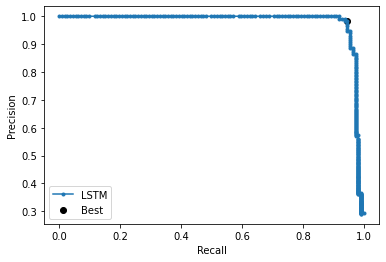

In [27]:
pyplot.plot(recall, precision, marker='.', label='LSTM')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [28]:
import numpy as np
test_predict = np.where(test_predict>0.222681, 1,0)
test_predict

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,

In [29]:
# confusion matrix
pd.crosstab(test_labels, test_predict)

col_0,0,1
label,,
0,722,2
1,7,105


In [30]:
from sklearn.metrics import confusion_matrix, classification_report

In [31]:
print(classification_report(test_labels, test_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       724
           1       0.98      0.94      0.96       112

    accuracy                           0.99       836
   macro avg       0.99      0.97      0.98       836
weighted avg       0.99      0.99      0.99       836



In [32]:
cm = confusion_matrix(test_labels, test_predict)

Text(33.0, 0.5, 'Truth')

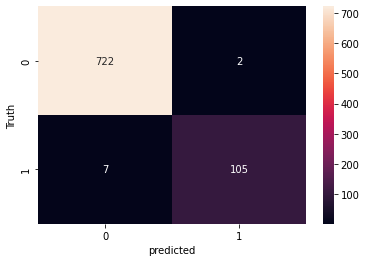

In [33]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm,annot=True, fmt='d')
plt.xlabel('predicted')
plt.ylabel('Truth')

In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(test_labels, test_predict, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(test_labels))]
p_fpr, p_tpr, _ = roc_curve(test_labels, random_probs, pos_label=1)

In [ ]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(test_labels, test_predict)

print(auc_score1)

0.9732142857142857


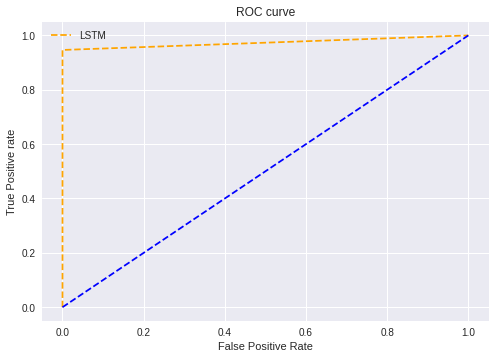

In [ ]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='LSTM')

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();